In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
reg_time = pd.read_csv("/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-zalomanina-41/shared/problem1-reg_data.csv",
                       encoding='windows-1251', sep=';')
reg_time
# дф с датами регистраций

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5
...,...,...
999995,1600874034,1110618
999996,1600874086,1110619
999997,1600874139,1110620
999998,1600874191,1110621


In [20]:
reg_time.isna().sum()
# проверяем дф на наличие отсутствующих данных

reg_ts    0
uid       0
dtype: int64

In [21]:
reg_time.loc[reg_time.duplicated()]
# и дубликатов

,reg_ts,uid


In [22]:
reg_time.dtypes
# проверяем типы данных

reg_ts    int64
uid       int64
dtype: object

In [23]:
auth_time = pd.read_csv("/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-zalomanina-41/shared/problem1-auth_data.csv",
                        encoding='windows-1251', sep=';')
auth_time
# дф с датами авторизаций меньше предыдущего по кол-ву строк

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2
...,...,...
9601008,1600874034,1110618
9601009,1600874086,1110619
9601010,1600874139,1110620
9601011,1600874191,1110621


In [24]:
1000000 - 9601013
# число авторизаций превышает число регистраций

-8601013

In [25]:
auth_time.isna().sum()
# отсутствующих данных нет

auth_ts    0
uid        0
dtype: int64

In [26]:
auth_time.loc[auth_time.duplicated()]
# как и дубликатов

,auth_ts,uid


In [27]:
reg_time.uid.nunique()

1000000

In [28]:
auth_time.uid.nunique()
# число уников в наших датафреймах одинаковое

1000000

In [29]:
auth_time.dtypes

auth_ts    int64
uid        int64
dtype: object

In [30]:
df = pd.merge(reg_time, auth_time, on='uid', how='inner')
df
# сращиваем датафреймы

,reg_ts,uid,auth_ts
0,911382223,1,911382223
1,932683089,2,932683089
2,932683089,2,932921206
3,932683089,2,933393015
4,932683089,2,933875379
...,...,...,...
9601008,1600874034,1110618,1600874034
9601009,1600874086,1110619,1600874086
9601010,1600874139,1110620,1600874139
9601011,1600874191,1110621,1600874191


In [31]:
df['difference'] = (df.auth_ts - df.reg_ts)
df['trash_bool'] = df['difference'] < 0
df['trash_bool'].unique()
# создаем колонку с разницей между авторизациями и регистрацией
# а также колонку, которая покажет, есть ли ошибки в данных - время регистрации более ранее, чем авторизации

array([False])

In [32]:
df['reg_date'] = pd.to_datetime(df['reg_ts'], unit='s')
df['auth_date'] = pd.to_datetime(df['auth_ts'], unit='s')
# переводим таймстемп в нормальную дату

In [33]:
# пишем функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

In [35]:
def retention(first_day, last_day): 
    """функция принимает на вход 2 даты - промежуток, который мы хотим исследовать"""
    
    ret_rate = df[(df['reg_date'] >= first_day) & (df['auth_date'] <= last_day)]
    """исходя из этих дат она будет рассчитывать процент удержания пользователей.
        иначе говоря, это наши когорты"""
    ret_rate['difference'] = (df.auth_date - df.reg_date).dt.days
    """колонка difference определяет разницу между авторизациями и регистрацией в днях"""
    ret_rate['reg_date'] = pd.to_datetime(df['reg_date'], unit='s').dt.floor('D')
    """колонка reg_date показывает дату вплоть до дня вместо таймстемпа"""
    
    ret_rate = ret_rate.groupby(['reg_date', 'difference'], as_index=False).agg({'uid': 'nunique'})
    """дф ret_rate группируем по этим двум колонкам, а значениями будут число уников """
    
    ret_pivot = ret_rate.pivot(index='reg_date', columns='difference', values='uid')
    retention = ret_pivot.divide(ret_pivot[0], axis=0).round(2).drop(columns=0)
    """собираем pivot на основе полученного дф. индексами будут дни, колонками - кол-во дней, значениями - кол-во уников
        создаем таблицу, которая заполняется результатами разбиения значений на первую колонку.
        значения в процентах будут округляться до двух знаков после точки"""
    
    plt.figure(figsize=(14, 8))
    sns.heatmap(retention, annot=True, cmap='coolwarm', vmin=0, fmt='0.1%', cbar_kws={'label': '\nRetention'})
    plt.title('% удержания по дням\n')
    plt.xlabel('\nСчетчик дней после регистрации')
    plt.ylabel('Дата регистрации\n')
    """визуализируем retention"""
    
    return retention

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


difference,1,2,3,4,5,6,7,8
reg_date,,,,,,,,
2017-01-01,0.06,0.05,0.09,0.14,0.06,0.07,0.07,0.03
2017-01-02,0.07,0.04,0.05,0.05,0.07,0.08,0.03,NaN
2017-01-03,0.04,0.06,0.06,0.03,0.09,0.06,NaN,NaN
2017-01-04,0.03,0.05,0.04,0.08,0.03,NaN,NaN,NaN
2017-01-05,0.06,0.04,0.07,0.05,NaN,NaN,NaN,NaN
2017-01-06,0.01,0.04,0.01,NaN,NaN,NaN,NaN,NaN
2017-01-07,0.05,0.03,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-08,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


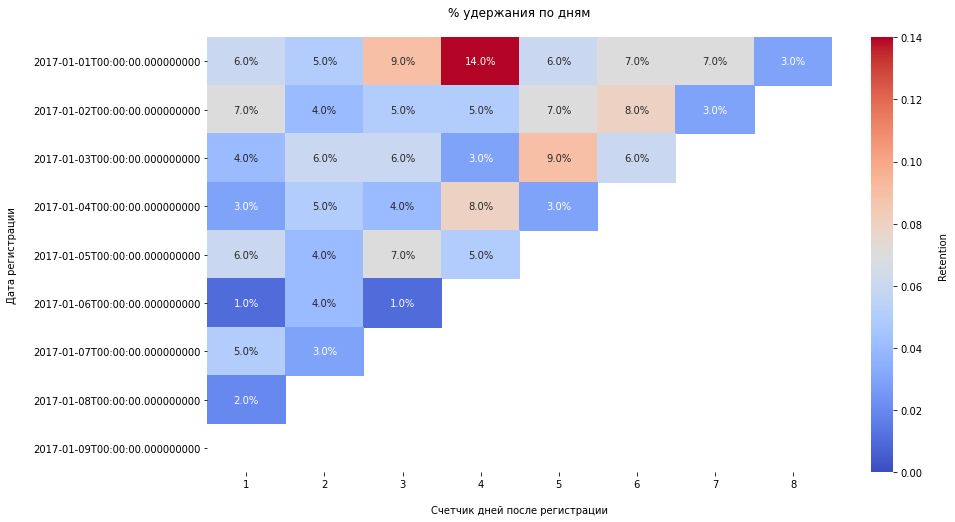

In [36]:
retention('2017-01-01', '2017-01-10')